In [1]:
!pip install transformers
!pip install datasets
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.4 MB/s eta 0:00:00


In [2]:
# Importing required libraries
import os
import pandas as pd
import string
import json
import jiwer
import IPython
import torch
import torchaudio
from torchaudio.transforms import Resample
from datasets import load_dataset
from transformers import Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2Processor
from transformers import Wav2Vec2ForCTC
from transformers import TrainingArguments
from transformers import Trainer


In [4]:
import tarfile
import os

# Path to the downloaded file
downloaded_tar_name = "/content/cv-corpus-8.0-2022-01-19-ur.tar.gz"
extracted_dir = "/content/cv-corpus-8.0-2022-01-19"

# Extract the dataset
if not os.path.exists(extracted_dir):
    print(f"Extracting {downloaded_tar_name}...")
    with tarfile.open(downloaded_tar_name, "r:gz") as tar:
        tar.extractall()
    print("Dataset extracted.")
else:
    print("Dataset already extracted.")

Extracting /content/cv-corpus-8.0-2022-01-19-ur.tar.gz...
Dataset extracted.


In [7]:
# Configuration Section
# Define constants for file paths and settings
data_url = 'cv-corpus-8.0-2022-01-19'
data_tar_file = 'commonvoice_ur.tar.gz'
data_audio_clips = f'{data_url}/ur/clips'
output_directory = 'processed_output'
model_save_directory = 'trained_model'
processor_save_directory = 'tokenizer_processor'

# Sampling rate for audio processing
AUDIO_SAMPLE_RATE = 16000

# Ensure Output Directories Exist
for directory in [output_directory, model_save_directory, processor_save_directory]:
    os.makedirs(directory, exist_ok=True)

In [8]:
# Loading dataset
# Define paths for train, dev, and test datasets
train_data_path = f'{data_url}/ur/train.tsv'
development_data_path = f'{data_url}/ur/dev.tsv'
test_data_path = f'{data_url}/ur/test.tsv'

# Load the datasets using HuggingFace's datasets library
data = load_dataset('csv', \
                   data_files={'train': [train_data_path, development_data_path], 'test': [test_data_path]}, \
                   delimiter='\t').remove_columns(['client_id', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'locale', 'segment'])

# Display dataset information
print(data['train'].to_pandas().head())
print(data['test'].to_pandas().head())

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

                           path  \
0  common_voice_ur_26630004.mp3   
1  common_voice_ur_26630005.mp3   
2  common_voice_ur_26630006.mp3   
3  common_voice_ur_26630007.mp3   
4  common_voice_ur_26630008.mp3   

                                            sentence  
0                        پر اپنی محنت سے حاصل کیا ہے  
1  جبکہ مصباح الحق اور یونس خان جیسے سینئرز صرف ا...  
2  پنجاب میں صنعتوں اور سی این جی سیکٹرز کو گیس ک...  
3                   لندن فلیٹس کی ملکیت ثابت شدہ ہے۔  
4                           کئی کئی برسوں کا فرق ہے۔  
                           path  \
0  common_voice_ur_27792069.mp3   
1  common_voice_ur_27792071.mp3   
2  common_voice_ur_27389484.mp3   
3  common_voice_ur_27389486.mp3   
4  common_voice_ur_26641307.mp3   

                                            sentence  
0  اور یہ رنگین لمحات آنکھوں اور دل میں محفوظ کر ...  
1  نئے نوٹوں کی بکنگ اپنی انتہائی حد تک پہنچنے کے...  
2            مانتے ہیں کہ ہر اچھائی خدا کی طرف سے ہے  
3                           

                           path  \
0  common_voice_ur_26630004.mp3   
1  common_voice_ur_26630005.mp3   
2  common_voice_ur_26630006.mp3   
3  common_voice_ur_26630007.mp3   
4  common_voice_ur_26630008.mp3   

                                            sentence  
0                        پر اپنی محنت سے حاصل کیا ہے  
1  جبکہ مصباح الحق اور یونس خان جیسے سینئرز صرف ا...  
2  پنجاب میں صنعتوں اور سی این جی سیکٹرز کو گیس ک...  
3                   لندن فلیٹس کی ملکیت ثابت شدہ ہے۔  
4                           کئی کئی برسوں کا فرق ہے۔  
                           path  \
0  common_voice_ur_27792069.mp3   
1  common_voice_ur_27792071.mp3   
2  common_voice_ur_27389484.mp3   
3  common_voice_ur_27389486.mp3   
4  common_voice_ur_26641307.mp3   

                                            sentence  
0  اور یہ رنگین لمحات آنکھوں اور دل میں محفوظ کر ...  
1  نئے نوٹوں کی بکنگ اپنی انتہائی حد تک پہنچنے کے...  
2            مانتے ہیں کہ ہر اچھائی خدا کی طرف سے ہے  
3                           

Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/341 [00:00<?, ? examples/s]

                           path  \
0  common_voice_ur_26630004.mp3   
1  common_voice_ur_26630005.mp3   
2  common_voice_ur_26630006.mp3   
3  common_voice_ur_26630007.mp3   
4  common_voice_ur_26630008.mp3   

                                            sentence  
0                        پر اپنی محنت سے حاصل کیا ہے  
1  جبکہ مصباح الحق اور یونس خان جیسے سینئرز صرف ا...  
2  پنجاب میں صنعتوں اور سی این جی سیکٹرز کو گیس ک...  
3                    لندن فلیٹس کی ملکیت ثابت شدہ ہے  
4                            کئی کئی برسوں کا فرق ہے  
                           path  \
0  common_voice_ur_27792069.mp3   
1  common_voice_ur_27792071.mp3   
2  common_voice_ur_27389484.mp3   
3  common_voice_ur_27389486.mp3   
4  common_voice_ur_26641307.mp3   

                                            sentence  
0  اور یہ رنگین لمحات آنکھوں اور دل میں محفوظ کر ...  
1  نئے نوٹوں کی بکنگ اپنی انتہائی حد تک پہنچنے کے...  
2            مانتے ہیں کہ ہر اچھائی خدا کی طرف سے ہے  
3                           

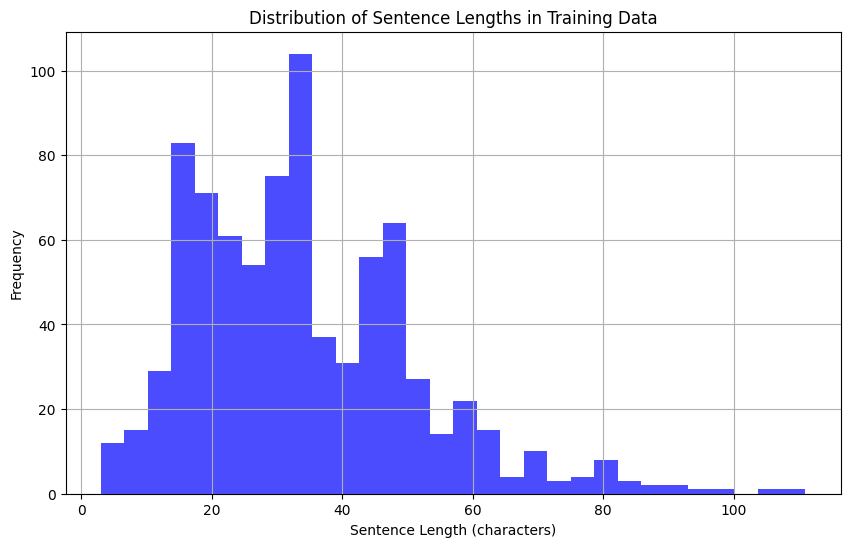

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


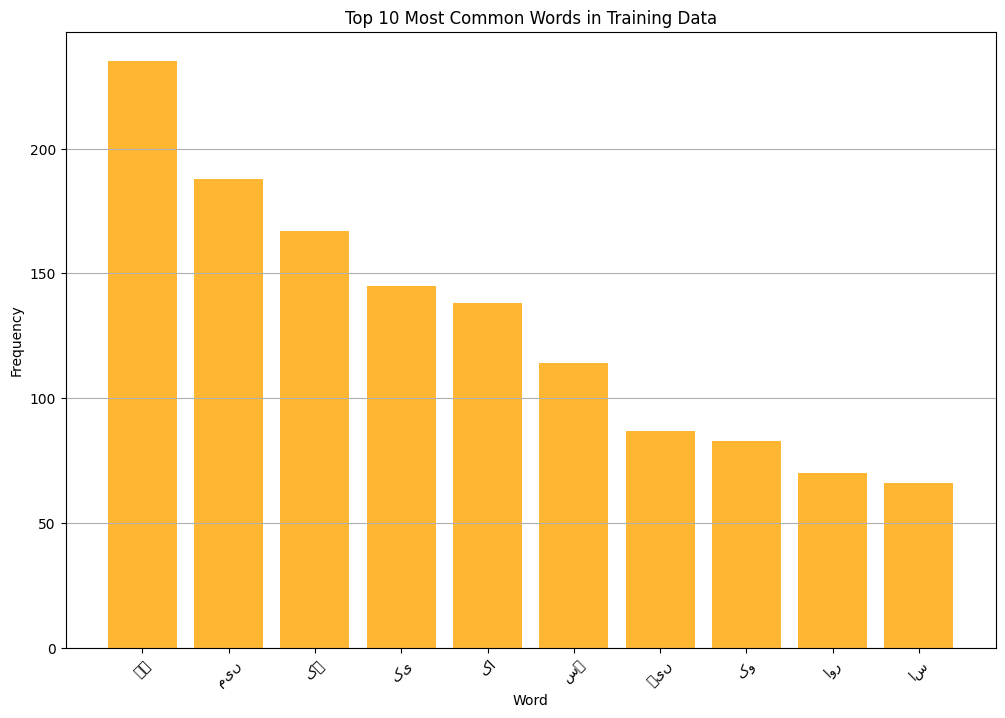

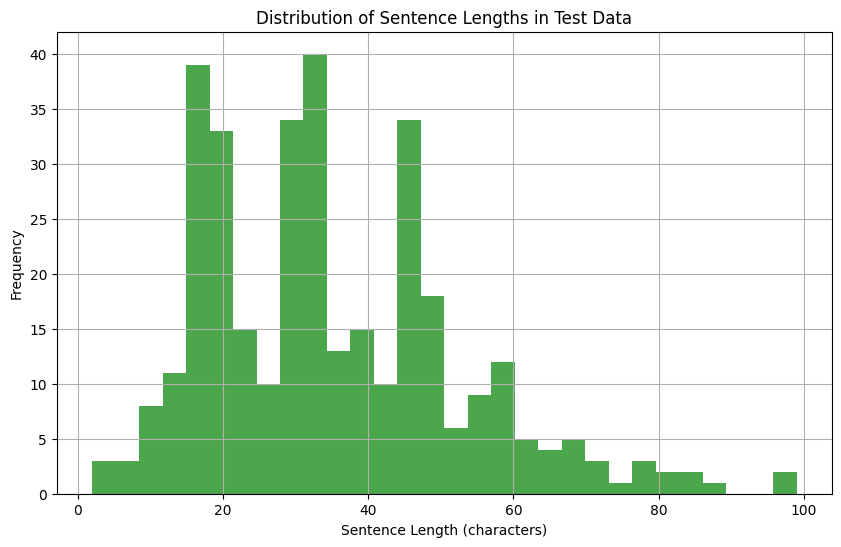

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


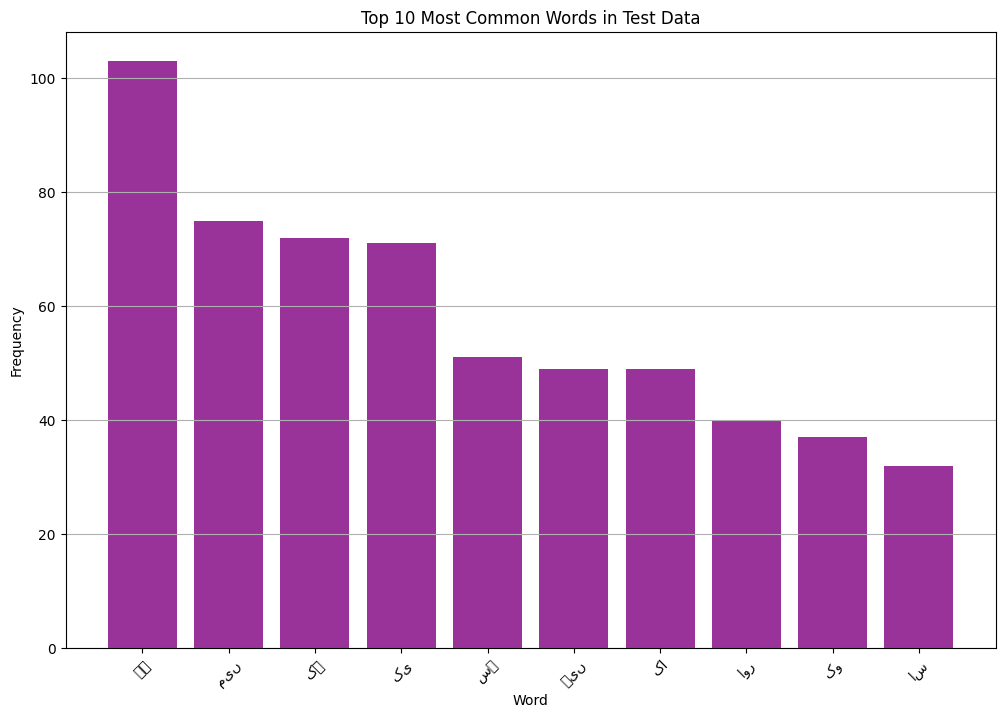

In [9]:
# Load the datasets using HuggingFace's datasets library
data = load_dataset('csv', \
                   data_files={'train': [train_data_path, development_data_path], 'test': [test_data_path]}, \
                   delimiter='\t').remove_columns(['client_id', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'locale', 'segment'])

# Display dataset information
print(data['train'].to_pandas().head())
print(data['test'].to_pandas().head())

# Remove punctuation from text
# Define custom punctuation for Urdu language and clean text
def clean_text(entry):
    custom_punct = string.punctuation + "۔؟،‘'ِ'ّ'ٔ’'ٓﷺ'ً'ؓ'َ'ٰ'ُ"
    entry['sentence'] = entry['sentence'].translate(str.maketrans('', '', custom_punct))
    return entry

data['train'] = data['train'].map(clean_text)
data['test'] = data['test'].map(clean_text)

# Display cleaned text data
print(data['train'].to_pandas().head())
print(data['test'].to_pandas().head())

# Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# Convert datasets to pandas DataFrames for EDA
train_df = data['train'].to_pandas()
test_df = data['test'].to_pandas()

# Sentence Length Distribution (Train)
train_df['sentence_length'] = train_df['sentence'].str.len()
plt.figure(figsize=(10, 6))
plt.hist(train_df['sentence_length'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Sentence Lengths in Training Data')
plt.xlabel('Sentence Length (characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Top 10 Most Common Words (Train)
word_counter = Counter(" ".join(train_df['sentence']).split())
common_words = pd.DataFrame(word_counter.most_common(10), columns=['Word', 'Frequency'])
plt.figure(figsize=(12, 8))
plt.bar(common_words['Word'], common_words['Frequency'], color='orange', alpha=0.8)
plt.title('Top 10 Most Common Words in Training Data')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Sentence Length Distribution (Test)
test_df['sentence_length'] = test_df['sentence'].str.len()
plt.figure(figsize=(10, 6))
plt.hist(test_df['sentence_length'], bins=30, color='green', alpha=0.7)
plt.title('Distribution of Sentence Lengths in Test Data')
plt.xlabel('Sentence Length (characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Top 10 Most Common Words (Test)
word_counter_test = Counter(" ".join(test_df['sentence']).split())
common_words_test = pd.DataFrame(word_counter_test.most_common(10), columns=['Word', 'Frequency'])
plt.figure(figsize=(12, 8))
plt.bar(common_words_test['Word'], common_words_test['Frequency'], color='purple', alpha=0.8)
plt.title('Top 10 Most Common Words in Test Data')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [10]:
# Remove punctuation from text
# Define custom punctuation for Urdu language and clean text
def clean_text(entry):
    custom_punct = string.punctuation + "۔؟،‘'ِ'ّ'ٔ’'ٓﷺ'ً'ؓ'َ'ٰ'ُ"
    entry['sentence'] = entry['sentence'].translate(str.maketrans('', '', custom_punct))
    return entry

data['train'] = data['train'].map(clean_text)
data['test'] = data['test'].map(clean_text)

# Display cleaned text data
print(data['train'].to_pandas().head())
print(data['test'].to_pandas().head())

Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/341 [00:00<?, ? examples/s]

                           path  \
0  common_voice_ur_26630004.mp3   
1  common_voice_ur_26630005.mp3   
2  common_voice_ur_26630006.mp3   
3  common_voice_ur_26630007.mp3   
4  common_voice_ur_26630008.mp3   

                                            sentence  
0                        پر اپنی محنت سے حاصل کیا ہے  
1  جبکہ مصباح الحق اور یونس خان جیسے سینئرز صرف ا...  
2  پنجاب میں صنعتوں اور سی این جی سیکٹرز کو گیس ک...  
3                    لندن فلیٹس کی ملکیت ثابت شدہ ہے  
4                            کئی کئی برسوں کا فرق ہے  
                           path  \
0  common_voice_ur_27792069.mp3   
1  common_voice_ur_27792071.mp3   
2  common_voice_ur_27389484.mp3   
3  common_voice_ur_27389486.mp3   
4  common_voice_ur_26641307.mp3   

                                            sentence  
0  اور یہ رنگین لمحات آنکھوں اور دل میں محفوظ کر ...  
1  نئے نوٹوں کی بکنگ اپنی انتہائی حد تک پہنچنے کے...  
2            مانتے ہیں کہ ہر اچھائی خدا کی طرف سے ہے  
3                           

In [11]:
# Generate and save vocabulary
# Extract unique characters from dataset sentences
def extract_vocabulary(sentences):
    unique_chars = {}
    char_count = 0
    for sentence in sentences:
        for char in sentence:
            if char not in unique_chars:
                unique_chars[char] = char_count
                char_count += 1
    return unique_chars

# Create vocabulary from test data
vocab = extract_vocabulary(data['test']['sentence'])
vocab['|'] = vocab[' ']
del vocab[' ']
vocab['<unk>'] = len(vocab)
vocab['<pad>'] = len(vocab)

# Save vocabulary as JSON
with open('vocabulary.json', 'w') as vocab_file:
    json.dump(vocab, vocab_file)


In [12]:
# Resample audio to uniform sampling rate
# Define a function to process audio files and resample them

y, sr = torchaudio.load(os.path.join(data_audio_clips, data['train']['path'][0]))
resample = Resample(sr, AUDIO_SAMPLE_RATE, dtype=torch.float32)
y = resample(y)
IPython.display.Audio(data=y, rate=AUDIO_SAMPLE_RATE)

def audio(entry):
    path = os.path.join(data_audio_clips, entry['path'])
    waveform, _ = torchaudio.load(path)
    entry['array'] = resample(waveform[0]).numpy()
    return entry

data['train'] = data['train'].map(audio)
data['test'] = data['test'].map(audio)

Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/341 [00:00<?, ? examples/s]

In [13]:
# Initialize Wav2Vec2 Processor
# Create tokenizer and feature extractor for Wav2Vec2
wav2vec_tokenizer = Wav2Vec2CTCTokenizer('vocabulary.json', unk_token='<unk>', pad_token='<pad>', word_delimiter_token='|')
feature_extractor = Wav2Vec2FeatureExtractor(return_attention_mask=True)
processor = Wav2Vec2Processor(feature_extractor, wav2vec_tokenizer)

# Prepare features and labels for the model
# Convert audio arrays into model input features
def prepare_features(entry):
    entry['input_values'] = processor(entry['array'], sampling_rate=AUDIO_SAMPLE_RATE).input_values[0]
    entry['input_length'] = len(entry['input_values'])

    with processor.as_target_processor():
        entry['labels'] = processor(entry['sentence']).input_ids

    return entry

data['train'] = data['train'].map(prepare_features, remove_columns=data['train'].column_names)
data['test'] = data['test'].map(prepare_features, remove_columns=data['test'].column_names)


Map:   0%|          | 0/810 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/341 [00:00<?, ? examples/s]

In [14]:
# Define custom data collator for padding
# Ensures batch padding for varying input lengths
import torch
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
@dataclass
class CustomDataCollator:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, samples: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{'input_values': sample['input_values']} for sample in samples]
        label_features = [{'input_ids': sample['labels']} for sample in samples]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors='pt',
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors='pt',
            )

        labels = labels_batch['input_ids'].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch['labels'] = labels

        return batch

collator = CustomDataCollator(processor=processor, padding=True)


In [16]:
# Load pre-trained Wav2Vec2 model
# Initialize model with pre-trained weights
pretrained_model = Wav2Vec2ForCTC.from_pretrained(
    'facebook/wav2vec2-xls-r-300m',
    attention_dropout=0.0,
    hidden_dropout=0.0,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.0,
    ctc_loss_reduction='mean',
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
)

# Freeze feature extractor layers
pretrained_model.freeze_feature_encoder()
pretrained_model.config.ctc_zero_infinity = True


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-xls-r-300m and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define training arguments for fine-tuning
training_args = TrainingArguments(
    output_dir=output_directory,
    group_by_length=True,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    evaluation_strategy='epoch',
    num_train_epochs=20,
    fp16=True,
    save_strategy='no',
    logging_steps=50,  # Log every 50 steps
    report_to='none'
)

# Trainer for fine-tuning the model
trainer = Trainer(
    model=pretrained_model,
    data_collator=collator,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    tokenizer=processor.feature_extractor
)

# Start training
trainer.train()

<ipython-input-17-565c986de07a>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Evaluate model performance
# Predict test dataset outputs and compute Word Error Rate (WER)
def evaluate_model(batch):
    with torch.no_grad():
        inputs = torch.tensor(batch['input_values'], device='cuda').unsqueeze(0)
        logits = pretrained_model(inputs).logits

    pred_ids = torch.argmax(logits, dim=-1)
    batch['predicted_text'] = processor.batch_decode(pred_ids)[0]
    batch['reference_text'] = processor.decode(batch['labels'], group_tokens=False)

    return batch

# Map predictions to test dataset
predicted_results = data['test'].map(evaluate_model, remove_columns=data['test'].column_names)

In [ ]:
predicted_results.to_pandas().head(10)

In [ ]:
model.save_pretrained(model_dir)
processor.save_pretrained(processor_dir)